# CRAFTY Web Scraping. Flavio Romano, 614801

In [34]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt

"""Datasets"""
transactions = pd.read_csv("./datasets/transactions.csv", names=["timestamp", "blockID", "txID", "isCoinbase", "fee"])
inputs = pd.read_csv("./datasets/inputs.csv", names=["txID", "prev_txID", "prev_txPos"])
outputs = pd.read_csv("./datasets/outputs.csv", names=["txID", "position", "addressID", "amount", "scriptType"])
mapping_df = pd.read_csv("./datasets/mapAddr2Ids8708820.csv", names=["hash", "addressID"])

### Analisi generali sui dati

In [35]:
transactions['timestamp'] = pd.to_datetime(transactions['timestamp'], unit='s')
print(transactions.head())
print(inputs.head())
print(outputs.head())
print(mapping_df.head())

            timestamp  blockID  txID  isCoinbase  fee
0 2009-01-09 03:54:39        9     9           1    0
1 2009-01-11 01:00:54       78    78           1    0
2 2009-01-12 03:30:25      170   171           0    0
3 2009-01-12 06:02:13      181   183           0    0
4 2009-01-12 06:12:16      182   185           0    0
   txID  prev_txID  prev_txPos
0   171          9           0
1   183        171           1
2   185        183           1
3   187        185           1
4   192        187           0
   txID  position  addressID      amount  scriptType
0     9         0          9  5000000000           1
1    78         0         78  5000000000           1
2   171         0        171  1000000000           1
3   171         1          9  4000000000           1
4   183         0        183  1000000000           1
                                 hash  addressID
0  1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa          0
1  12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX          1
2  1HLoD9E4SDFFPDiYfNYnkB

### Distribuzione del numero di transazioni per blocco (occupazione del blocco), nell’intero periodo temporale considerato

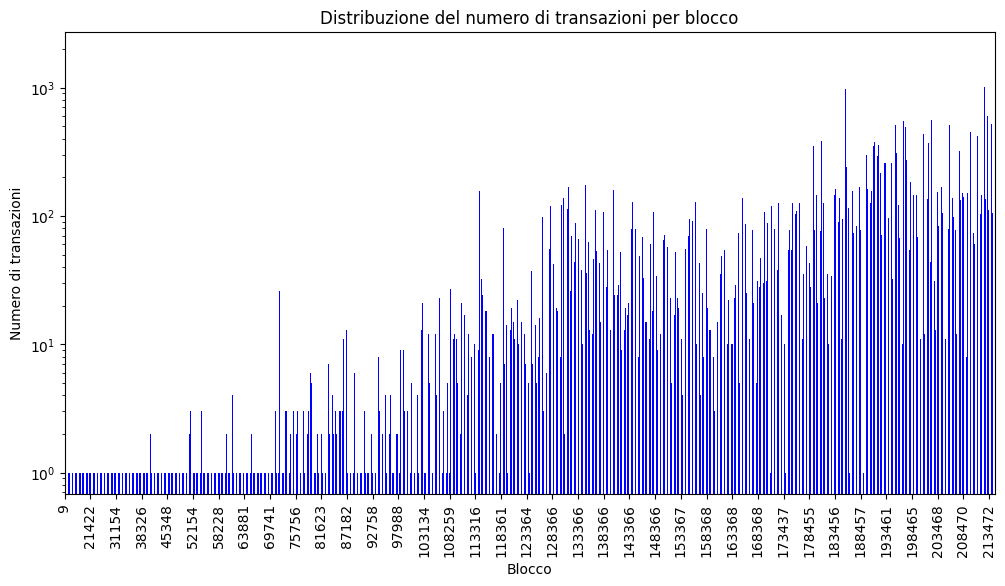

In [36]:
transactions_per_block = transactions.groupby("blockID")["txID"].count()

plt.figure(figsize=(12, 6))
transactions_per_block.plot(kind="bar", color="blue")
plt.xlabel("Blocco")
plt.ylabel("Numero di transazioni")
plt.title("Distribuzione del numero di transazioni per blocco")

plt.yscale("log")

x_ticks = range(0, len(transactions_per_block), 5000)
plt.xticks(x_ticks, transactions_per_block.index[x_ticks])

plt.show()

### Evoluzione dell'occupazione dei blocchi nel tempo

<Figure size 1200x600 with 0 Axes>

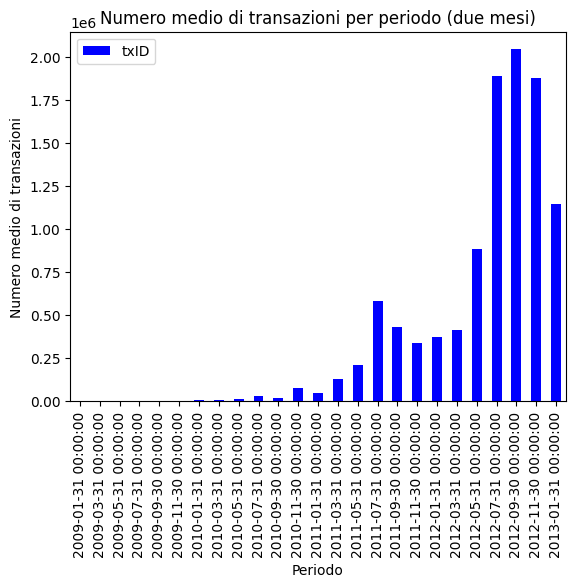

<Figure size 1200x1000 with 0 Axes>

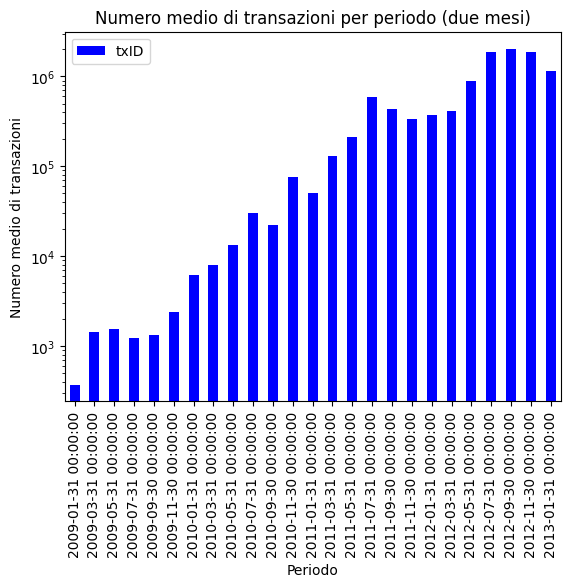

In [51]:
avg_transactions_per_period = transactions[["timestamp", 'txID']].resample(
    '2M', on="timestamp").count()

plt.figure(figsize=(12, 6))
avg_transactions_per_period.plot(kind='bar', color='blue')

plt.xlabel('Periodo')
plt.ylabel('Numero medio di transazioni')
plt.title('Numero medio di transazioni per periodo (due mesi)')

plt.show()

plt.figure(figsize=(12,10))
avg_transactions_per_period.plot(kind='bar', color='blue')

plt.xlabel('Periodo')
plt.ylabel('Numero medio di transazioni')
plt.title('Numero medio di transazioni per periodo (due mesi)')
plt.yscale("log")

plt.show()